In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

This module is about the **Markowitz Mean-Variance Portfolio Theoy (MVP)**. We need to retrieve some stock price data first to have something to work with. We build a portfolio of **tech companies**.

In [2]:
symbols = ['AAPL', 'MSFT', 'YHOO', 'AMZN', 'GOOG']  # our symbols
data = pd.DataFrame()  # empty DataFrame
for sym in symbols:
    data[sym] = web.DataReader(sym, data_source='google')['Close']

Let us inspect the **final five rows** of the `DataFrame` object.

In [3]:
data.tail()  # the final five rows

,AAPL,MSFT,YHOO,AMZN,GOOG
Date,,,,,
2017-07-24,152.09,73.60,58.15,1038.95,980.34
2017-07-25,152.74,74.19,58.07,1039.87,950.70
2017-07-26,153.46,74.05,58.90,1052.80,947.80
2017-07-27,150.56,73.16,58.43,1046.00,934.09
2017-07-28,149.50,73.04,59.20,1020.04,941.53


A **graphical comparison** of the complete time series data might also be helpful. We **normalize** the starting values to 100.

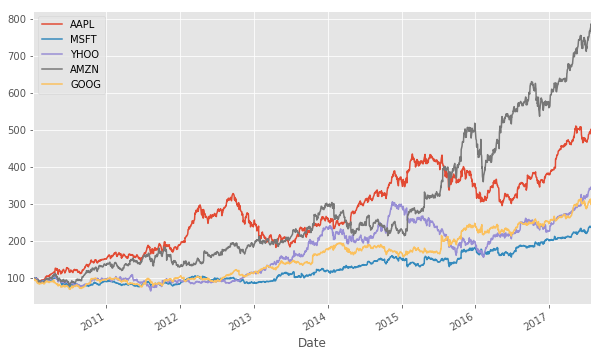

In [5]:
(data / data.ix[0] * 100).plot(figsize=(10, 6));

## Portfolio Returns

The first step in the calculation of a portfolio return is the calculation of the **annualized returns** of the different stocks based on the log returns for the respective time series.

In [6]:
# vectorized calculation of the log returns
log_rets = np.log(data / data.shift(1))

In [7]:
# annualized average log returns
rets = log_rets.mean() * 252
rets

AAPL    0.210081
MSFT    0.113643
YHOO    0.164362
AMZN    0.268743
GOOG    0.145735
dtype: float64

We now need to represent a **portfolio** by (normalized) weightings for the single stocks. Let us start with an equal weighting scheme.

In [8]:
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])  # equal weightings

In mathematical terms, the portfolio return is given as

\begin{eqnarray*}
\mu_p &=& \mathbf{E} \left( \sum_I w_i r_i \right) \\
        &=& \sum_I w_i \mathbf{E}\left( r_i \right) \\
        &=& \sum_I w_i \mu_i \\
        &=& w^T \mu
\end{eqnarray*}

where the $w_i$ are the weights for the single portfolio components and the $r_i$ are the respective returns.

We get for our specific case the following result.

In [9]:
np.dot(weights, rets)  # portfolio return (equal weights)

0.18051272965959389

## Portfolio Variance

The calculation of the **portfolio variance** is a bit more involved. Let us start with the definition of the **covariance matrix** which is needed to this end.

\begin{eqnarray*}
\Sigma = \begin{bmatrix}
        \sigma_{1}^2 \ \sigma_{12} \ \dots \ \sigma_{1I} \\
        \sigma_{21} \ \sigma_{2}^2 \ \dots \ \sigma_{2I} \\
        \vdots \ \vdots \ \ddots \ \vdots \\
        \sigma_{I1} \ \sigma_{I2} \ \dots \ \sigma_{I}^2
    \end{bmatrix}
\end{eqnarray*}

Here, we have the variances of the single stocks on the diagonal and the covariances between two stocks in the other places.

In Python, this matrix is easily calculated.

In [10]:
log_rets.cov() * 252  # annualized covariance matrix

,AAPL,MSFT,YHOO,AMZN,GOOG
AAPL,0.065779,0.022743,0.023439,0.026780,0.025831
MSFT,0.022743,0.051064,0.025458,0.028812,0.026153
YHOO,0.023439,0.025458,0.088897,0.037406,0.030824
AMZN,0.026780,0.028812,0.037406,0.098447,0.039355
GOOG,0.025831,0.026153,0.030824,0.039355,0.058687


Being equipped with the covariance matrix, the **portfolio variance** is defined as follows.

\begin{eqnarray*}
\sigma_p^2 &=& \mathbf{E}\left( (r - \mu)^2 \right) \\
        &=& \sum_{i \in I}\sum_{j \in I} w_i w_j \sigma_{ij} \\
        &=& w^T \Sigma w
\end{eqnarray*}

In Python, using NumPy, this is again a straightforward calculation.

In [11]:
# portfolio variance
pvar = np.dot(weights.T, np.dot(log_rets.cov() * 252, weights))
pvar

0.037458996071931691

The **portfolio volatility** then is

In [12]:
pvol = pvar ** 0.5
pvol

0.19354326666647872

## Random Portfolio Compositions

Next, let us generate a **random portfolio composition** and calculate the resulting portfolio return and variance.

In [13]:
weights = np.random.random(5)  # random numbers
weights /= np.sum(weights)  # normalization to 1

In [14]:
weights  # random portfolio composition

array([ 0.28787307,  0.22353269,  0.08510868,  0.2790184 ,  0.12446715])

In [15]:
np.dot(weights, rets)  # portfolio return (random weights)

0.19299162839611833

In [16]:
# portfolio variance (random weights)
np.dot(weights.T, np.dot(log_rets.cov() * 252, weights))

0.038629540489666186

We are now going to implement a **Monte Carlo simulation** for the portfolio weights and collect the resulting portfolio returns and volatilities.

In [17]:
%%time
prets = []
pvols = []
for p in xrange(5000):
    weights = np.random.random(5)
    weights /= np.sum(weights)
    prets.append(np.sum(log_rets.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(log_rets.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)
portfolio = pd.DataFrame({'return': prets, 'volatility': pvols})

CPU times: user 4.86 s, sys: 13 ms, total: 4.87 s
Wall time: 4.88 s


The collected results allow for an **insightful visualization**. We can easily spot the area of the **minimum variance portfolio** and also see the **efficient frontier** quite well.

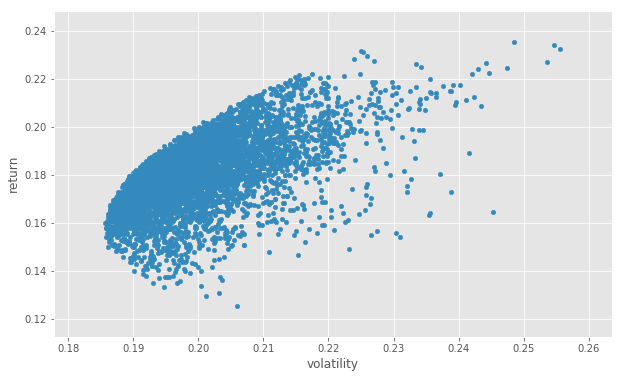

In [18]:
portfolio.plot(x='volatility', y='return', kind='scatter', figsize=(10, 6));

## Closing Remarks

This finishes the third module of the Python for Finance email course. In this module, you have learned:

* how to collect stock price data for multiple symbols
* how to calculate the return of a portfolio of multiple assets
* how to calculate the portfolio variance by the use of the covariance matrix
* how to simulate random portfolio compositions to visualize possible risk-return combinations

The portfolio theory presented in this module dates back to 1952 and is still a cornerstone today in (quantitative) finance.

## Exercises

In order to master the material of this module, do the following:

* replace the symbols used by other symbols and/or add more symbols
* work with different time horizons for the input data
* write Python code to find the minimum variance portfolio
* write Python code to find the portfolio compositions that make up the efficient frontier
* write Python code to determine the capital market line given a risk-free asset

## References

You find background information for the topics covered in this module in the following book:

* Hilpisch, Yves (2014): _Python for Finance_. O'Reilly, ch. 11.